In [5]:
########################################
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import os
import time

########################################
#PARAMETERS
nTimeSteps = 30 #seconds
samplenum = 10
epochs = 100
minibatch_size= 5
hiddenlayers = [100]
input_size = 9 # q (0:3), qdot (3:6), current p (6:9) 
output_size = 3*nTimeSteps
learning_rate = 0.01
LRdecay = 0.7
use_case = 'qhold'
model_file_path = '../Trained_Models/'
simulation_file_path = '../Data/Simulations/pm_target.sim'
objective_file_path = f'../Data/Objectives/pm_qhold_{nTimeSteps}.obj'

# set log level
dde.set_log_level(dde.LogLevel.off)

#######################################
# LOAD SIMULATION AND OBJECTIVE FUNCTION
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

# Objective Function
obj = dde.InverseObjective(dyn)
obj.loadFile(objective_file_path)
objective_json = json.load(open(objective_file_path))
opt = dde.Newton()

##########################################
#SAMPLE TARGETS
data = np.zeros((samplenum,input_size))
for i in range(input_size):
    data[:,i] = np.random.rand(samplenum)
data[:, 6:9] = data[:, 6:9]*3-1
data[:, 3:6] = data[:, 3:6]-0.5
p_start = np.zeros((samplenum,3))
for i in range(samplenum):
    p_start[i, :] = data[i, 6:9]
q_truth = np.zeros((samplenum, 3*nTimeSteps))
q_seq = np.zeros((3*nTimeSteps))
for i in range(samplenum):
    for k in range(nTimeSteps):
	    q_seq[k*3 : (k+1)*3] = data[i, 0:3]
    q_truth[i, :] = q_seq
p_start = torch.tensor(p_start).float()
data = torch.tensor(data).float()
q_truth = torch.tensor(q_truth).float()
print("done")

done
Help on module pydde:

NAME
    pydde

MODULE REFERENCE
    https://docs.python.org/3.7/library/pydde
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        DynamicSequence
        LBFGS
        LogLevel
        Newton
        ObjectiveFunction
            InverseObjective
            InverseParmeterizedObjective
        ParameterSetup
        Simulation
        StateTrajectory
    
    class DynamicSequence(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      DynamicSequence
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(...)
 

In [49]:
##########################################
#BUILD CUSTOM SIMULATION FUNCTION
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, data):
        #print(f'input: {input.shape}')
        p = input.clone().numpy().transpose()
        q_pred = torch.ones([len(p[0, :]),3*nTimeSteps])
        for i in range(len(p[0, :])):
            dyn.p0 = data[i, 6:9]
            dyn.q0 = data[i, 0:3]
            dyn.qdot0 = data[i, 3:6]
            state = dyn.q(p[:,i])
            q_pred[i, :] = torch.tensor(state.q)
        #print(f'q_pred: {q_pred.shape}')
        
        ctx.save_for_backward(input)
        
        return q_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, = ctx.saved_tensors
        p = input.clone().numpy().transpose()
        dq_dp_batch = torch.zeros([3*nTimeSteps, 3*nTimeSteps])
        for i in range(len(p[0, :])):
            state = dyn.q(p[:, i])
            dq_dp = dyn.dq_dp(state, p[:, i])
            dq_dp = torch.tensor(dq_dp)
            dq_dp_batch = dq_dp_batch + dq_dp
        #print(f'dq/dp_batch: {dy_dp_batch/samplenum}')
        
        grad_input = grad_output.mm(dq_dp_batch.float()/len(p[0,:]))
        #print(f'shape of grad input: {grad_input.shape}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input, None

Simulate = Simulate.apply

########################################
#BUILD CUSTOM MODEL
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*nTimeSteps)
        self.L_out = nn.Linear(3*nTimeSteps, 3*nTimeSteps)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = ActiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)
print("done")

done


In [50]:
####################################################
#TRAIN THE MODEL
torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 2 # basic error
weight_c2 = 1 # p start condition
weight_c3 = 1 # p smoothness condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
smoothness_errors = []
p_start_errors = []
q_end_errors = [] #q_end error
for e in range(epochs):
    for b in range(batch):
        input_b = data[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_b = model(input_b)
        q_pred = Simulate(p_b, input_b)
        #smoothness_error_i = weight_c3*(p_i[0:3*(nTimeSteps-1)] - p_i[3:3*nTimeSteps]).pow(2).sum()
        smoothness_error = weight_c3*criterion(p_b[:, 0:3*(nTimeSteps-1)], p_b[:, 3:3*nTimeSteps])
        #p_start_error = weight_c2*torch.sqrt(criterion(p_i[0:3], torch.tensor(dyn.p_init[0:3])))
        p_start_error = weight_c2*criterion(p_b[:, 0:3], p_start[b*minibatch_size:b*minibatch_size+minibatch_size,:])
        #q_end_error = torch.sqrt(criterion(q_pred, q_i))
        q_end_error = weight_c1*criterion(q_pred, q_truth[b*minibatch_size:b*minibatch_size+minibatch_size,:])
        loss = q_end_error + p_start_error + smoothness_error
        #loss = loss_batch/minibatch_size
        losses.append(loss)
        #smoothness_error = smoothness_error_batch/minibatch_size
        smoothness_errors.append(smoothness_error)
        q_end_errors.append(q_end_error)
        p_start_errors.append(p_start_error)
        optimizer.zero_grad()
        #Backpropagation
        loss.backward()
        optimizer.step()
    if e%(epochs/10) == 0:
        print(f'epoch: {e:3}/{epochs}  loss: {loss.item():10.8f}   basic_loss: {q_end_error.item():10.8f}')

print(f'epoch: {e:3} finale loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

epoch:   0/100  loss: 0.39319295   basic_loss: 0.15293945
epoch:  10/100  loss: 0.04719301   basic_loss: 0.01835001
epoch:  20/100  loss: 0.02402657   basic_loss: 0.01292337
epoch:  30/100  loss: 0.00928756   basic_loss: 0.00262415
epoch:  40/100  loss: 0.00673273   basic_loss: 0.00166421
epoch:  50/100  loss: 0.00627667   basic_loss: 0.00150014
epoch:  60/100  loss: 0.00610701   basic_loss: 0.00141310
epoch:  70/100  loss: 0.00603517   basic_loss: 0.00138009
epoch:  80/100  loss: 0.00600317   basic_loss: 0.00134554
epoch:  90/100  loss: 0.00598352   basic_loss: 0.00132389
epoch:  99 finale loss: 0.00597162

Duration: 1.524 min


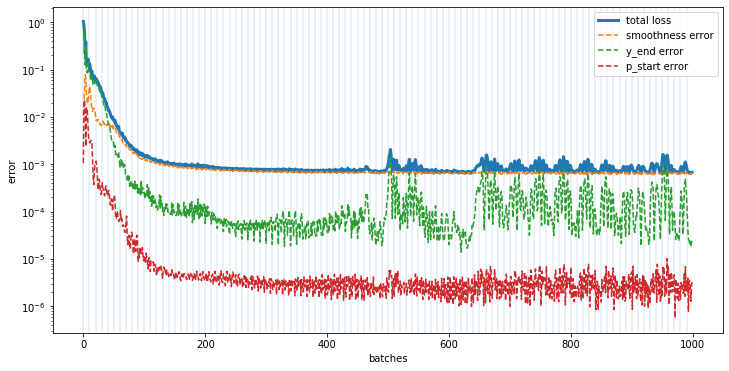

In [19]:
##################################################
#PLOT EVERY LOSS COMPONENT FOR EACH BATCH
timestr = time.strftime("%m%d")
epoch_lines = np.arange(0, epochs*batch, batch)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(smoothness_errors, label = 'smoothness error', linestyle='--')
q_end = plt.plot(q_end_errors, label = 'y_end error', linestyle='--')
p_start = plt.plot(p_start_errors, label = 'p_start error', linestyle='--')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.savefig('../Plots/Loss_' + use_case + '_' + timestr + '.png')
plt.show()

In [18]:
#####################################################
#SAVE MODEL
timestr = time.strftime("%m%d")
#Save entire Model
torch.save(model, model_file_path + 'Model_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model, model_file_path + 'Model_active_' + use_case + '_{nTimeSteps}tsteps_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), model_file_path + 'state_dict/Trained_Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_active_' + use_case + '_{nTimeSteps}tsteps_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = data[4, :]
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')
traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
print('Model saved')

## Test forward propagation

In [15]:
y_target_test= torch.tensor([0, 2, 0.5])
p = model(y_target_test)
y_pred = Simulate(p)
y_target = y_target_test.detach().numpy()
p = p.detach().numpy()


yTraj_test = dyn.compute(p)

print(yTraj_test.y)
print(np.sum(yTraj_test.y[-3:]-y_target))
print(p)

[ 7.06265214e-05  1.94512096e+00 -2.41065371e-03  3.31315787e-05
  1.92802432e+00 -1.53361098e-03 -2.50241846e-05  1.92932236e+00
  1.56063603e-03 -9.71003644e-05  1.93428661e+00  5.38268862e-03
 -1.62618436e-04  1.93360197e+00  8.86586868e-03 -2.25301555e-04
  1.93395067e+00  1.28316244e-02 -2.85834693e-04  1.93429806e+00
  1.71687823e-02 -3.50448650e-04  1.93525816e+00  2.19732797e-02
 -4.14815980e-04  1.93375367e+00  2.68146188e-02 -4.72172313e-04
  1.93669103e+00  3.27430476e-02 -5.28714245e-04  1.93759710e+00
  3.87745118e-02 -5.78609289e-04  1.93827448e+00  4.51808948e-02
 -6.33160244e-04  1.94006216e+00  5.21617538e-02 -6.88252925e-04
  1.93954718e+00  5.92062964e-02 -7.34688687e-04  1.94146587e+00
  6.70216432e-02 -7.42094754e-04  1.94816654e+00  7.59523267e-02
 -7.49759755e-04  1.95197583e+00  8.48596589e-02 -7.56351785e-04
  1.95427444e+00  9.39290308e-02 -7.62178840e-04  1.95308895e+00
  1.02900194e-01 -7.64573918e-04  1.95149467e+00  1.12150193e-01
 -7.47805104e-04  1.95606